In [1]:
import numpy
import csv
import re
import pandas as pd
b = '../Data/'

In [2]:
import warnings
warnings.filterwarnings("default")

In [3]:
a = pd.ExcelFile(b + "currencies_fixed_4.xlsx")
tables = []
for sheet in a.sheet_names:
    tables.append(pd.read_excel(b + "currencies_fixed_4.xlsx", sheet))

In [4]:
result_table = pd.concat(tables)

In [16]:
text = 'Text EN'

In [21]:
result_table[[text, 'Recommendations EN\n']]

,Text EN,Recommendations EN\n
0,The Australian dollar started the week with we...,-\n
1,AUD is struggling to gain momentum over JPY re...,-\n
2,AUD/JPY has been rejected off the 80.50 resist...,-\n
3,The Australian economy is currently going thro...,-\n
4,The Australian economy is experiencing a decl...,-\n
...,...,...
194,After rejecting off the resistance of 111.60 r...,-\n
195,USD/JPY has been in a bullish non-volatile tre...,-\n
196,USDJPY has been in a bullish trend since the s...,-\n
197,USD/JPY has shown a good amount of strength re...,-\n


In [22]:
clearTable = result_table[(result_table['Nearest Closing Time'] != '-') & (result_table[text] != '-')]

In [24]:
clearTable.rename(columns={text: 'Text'}, inplace=True)

clearTable['Text'] = clearTable['Text'].map(lambda x: re.sub('[^A-Za-z ]', " ", x))
clearTable['Text'].iloc[0]

'The Australian dollar started the week with weak economic reports and events which  Today the aussie extended losses as the employment change report moved drastically below the expected value Today the Australian employment change report was published with a decrease to    K from the previous figure of     K which was expected to be at    K  At the same time  the unemployment rate remained unchanged at      as expected  The Australian Bureau of Statistics reported about creation of         new jobs last month as a slump in part time work overshadowed a        jump in full time employment  However  the overall employment change statistics were downbeat which put the market into indecision  The RBA has recently estimated that the jobless rate will need to fall to      to generate any wage pressures  In order to achieve that level  it chopped interest rates twice since June to a record low of    as the economy grapples with subdued home prices and miserly consumer spending Another rate c

In [26]:
import datetime
top4 = clearTable[(clearTable['Currency'] == 'EUR/USD') | (clearTable['Currency'] == 'GBP/USD') | (clearTable['Currency'] == 'EURUSD') | (clearTable['Currency'] == 'AUD/USD')]
superTable = top4[['Currency', 'Text', 'Nearest Closing Time']]
superTable['Nearest Closing Time'] = superTable['Nearest Closing Time'].map(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d%H%M").date())
superTable['Nearest Closing Time'].map(lambda x: x.year).value_counts()

C:\Users\Andrei\AppData\Local\Temp\ipykernel_3744\2580906241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  superTable['Nearest Closing Time'] = superTable['Nearest Closing Time'].map(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d%H%M").date())


2020    1358
2021     688
2019     366
2018     136
2017      28
Name: Nearest Closing Time, dtype: int64

In [27]:
audusd = b + r"AUDUSD_170101_220818.txt"
gbpusd = b + r"GBPUSD_170101_220818.txt"
eurusd = b + r"EURUSD_170101_220818.txt"

In [28]:
aud = pd.read_csv(audusd, sep=',')
gbp = pd.read_csv(gbpusd, sep=',')
eur = pd.read_csv(eurusd, sep=',')

In [29]:
for i in [aud, gbp, eur]:
    i['<DATE>'] = i['<DATE>'].map(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d").date())
    i.drop(['<TIME>', '<TICKER>', '<PER>', '<HIGH>', '<LOW>', '<VOL>'], axis=1, inplace=True)
    i['Target'] = (i['<CLOSE>'] > i['<OPEN>']).apply(lambda x: int(x))
    i.drop(['<OPEN>', '<CLOSE>'], axis=1, inplace=True)
    i.rename(columns={'<DATE>':'Date'}, inplace=True)

In [30]:
superTable.rename(columns={'Nearest Closing Time': 'Date'}, inplace=True)
data = superTable

C:\Users\Andrei\AppData\Local\Temp\ipykernel_3744\2026520606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  superTable.rename(columns={'Nearest Closing Time': 'Date'}, inplace=True)


In [36]:
eData = data[(data['Currency'] == 'EUR/USD') | (data['Currency'] == 'EURUSD')]
aData = data[(data['Currency'] == 'AUD/USD')]
gData = data[data['Currency'] == 'GBP/USD']
e = eData.set_index('Date').join(eur.set_index('Date'), on='Date')
a = aData.set_index('Date').join(aud.set_index('Date'), on='Date')
g = gData.set_index('Date').join(gbp.set_index('Date'), on='Date')
final_data = pd.concat([e, a, g])
final_data['Text'] = final_data['Text'].map(lambda x: x.lower())

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [39]:
final_data = final_data.drop_duplicates('Text')
final_data_without_na = final_data[final_data['Target'].notna()]
final_data_without_na['Target'].value_counts()
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')
final_data_without_na['Text'] = final_data_without_na['Text'].apply(lambda x:\
                            ' '.join([word for word in x.split() if word not in russian_stopwords]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrei\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [40]:
X, y = final_data_without_na['Text'], final_data_without_na['Target']

In [41]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=0.85, random_state=1)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv_bigram, cv_word = CountVectorizer(ngram_range=(2,2)), CountVectorizer(ngram_range=(1,1))
tfid_bigram, tfid_word = TfidfVectorizer(ngram_range=(2, 2)), TfidfVectorizer(ngram_range=(1, 1), max_df=0.3)

X, X1, X_cv_bigram, X_cv_word = tfid_bigram.fit_transform(x_train), tfid_word.fit_transform(x_train), cv_bigram.fit_transform(x_train), cv_word.fit_transform(x_train)
X_test, X_test1, X_test_cv_bigram, X_test_cv_word = tfid_bigram.transform(x_valid), tfid_word.transform(x_valid), cv_bigram.transform(x_valid), cv_word.transform(x_valid)

# Some visualisations

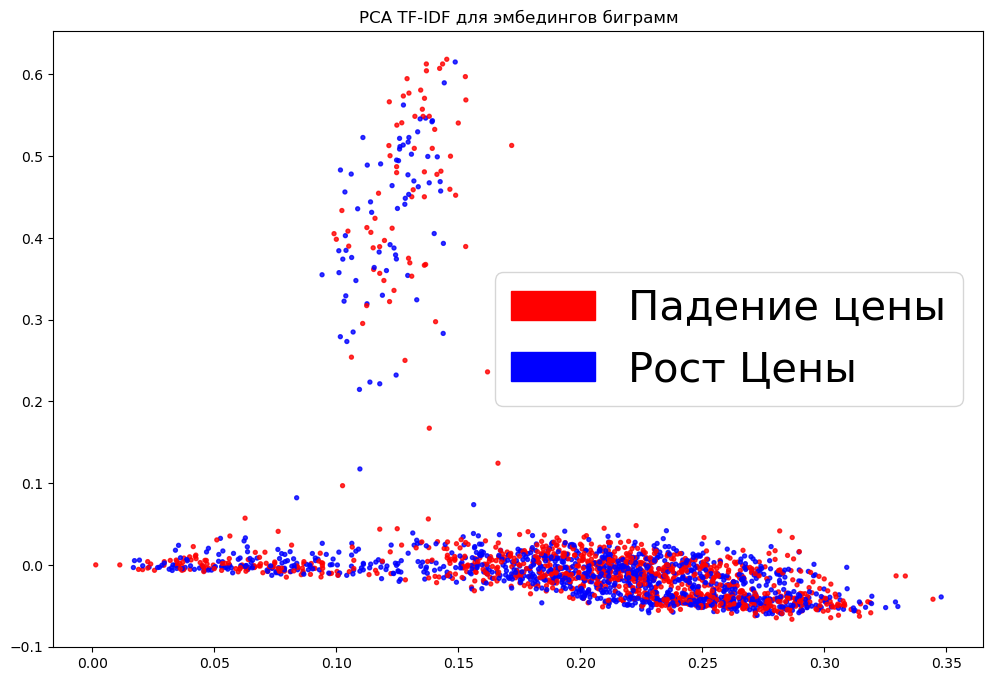

In [43]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt 


def plot_LSA(test_data, test_labels, title, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['red','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='Red', label='Падение цены')
            green_patch = mpatches.Patch(color='Blue', label='Рост Цены')
            plt.title(title)
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(12, 8))          
plot_LSA(X, y_train, 'PCA TF-IDF для эмбедингов биграмм')
plt.show()

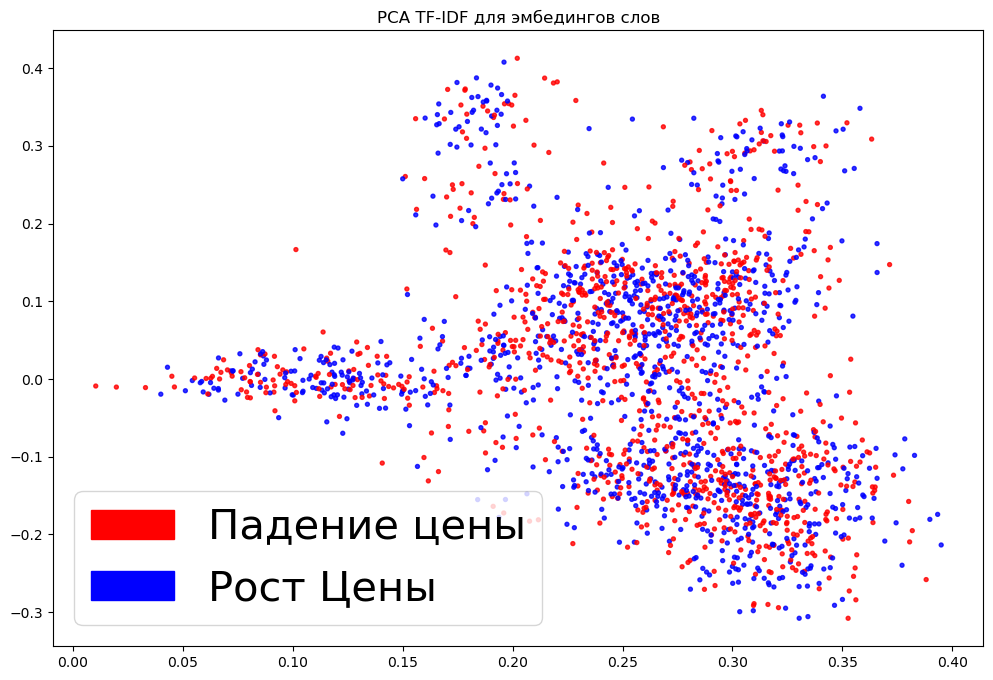

In [44]:
plt.figure(figsize=(12, 8))
plot_LSA(X1, y_train, 'PCA TF-IDF для эмбедингов слов')
plt.show()

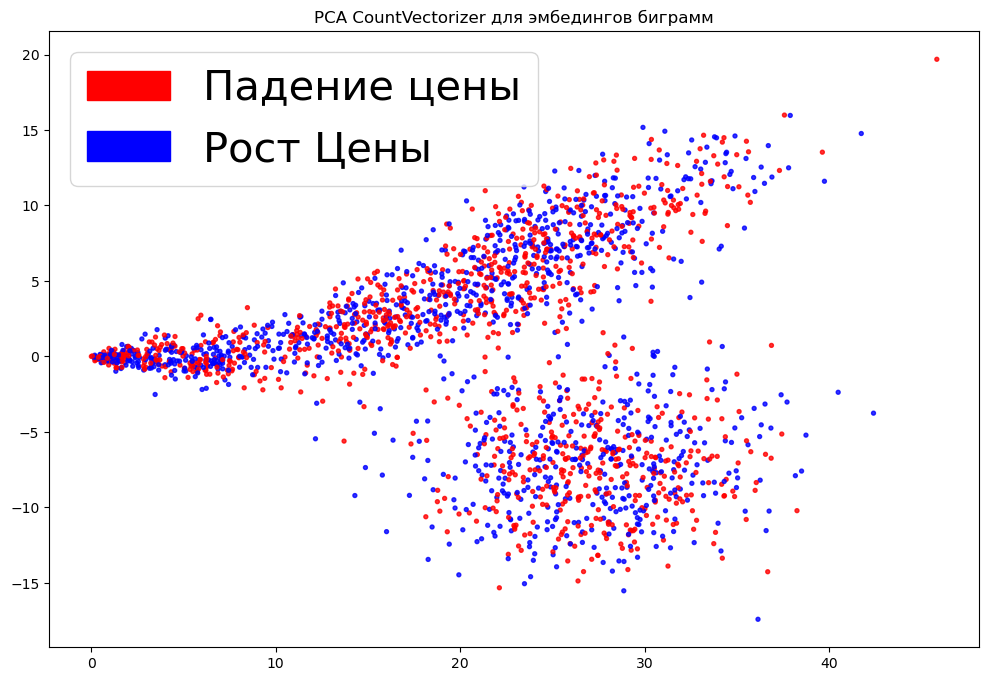

In [45]:
plt.figure(figsize=(12, 8))
plot_LSA(X_cv_bigram, y_train, 'PCA CountVectorizer для эмбедингов биграмм')
plt.show()

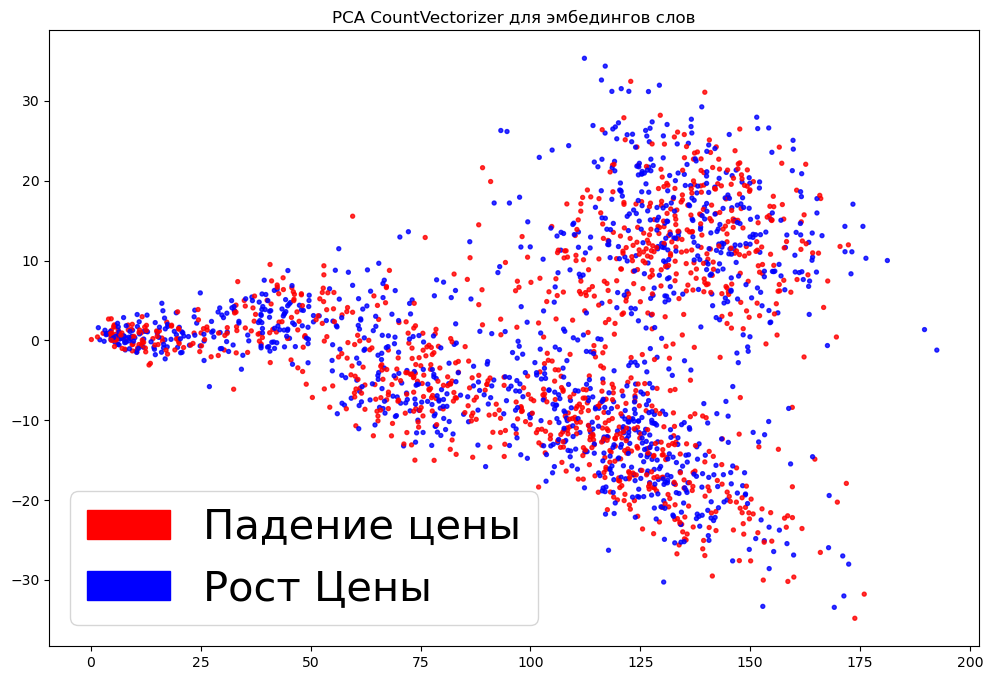

In [46]:
plt.figure(figsize=(12, 8))
plot_LSA(X_cv_word, y_train, 'PCA CountVectorizer для эмбедингов слов')
plt.show()

# Cross-validation

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([('TfidfVectorizer', TfidfVectorizer(ngram_range=(2, 2))), \
                ('SGD', SGDClassifier(n_jobs=-1))])
pipe1 = Pipeline([('TfidfVectorizer', TfidfVectorizer(ngram_range=(1,1))), \
                ('SGD', SGDClassifier(n_jobs=-1))])
pipe2 = Pipeline([('CountVectorizer', CountVectorizer(ngram_range=(1,1))), \
                ('SGD', SGDClassifier(n_jobs=-1))])
pipe3 = Pipeline([('CountVectorizer', CountVectorizer(ngram_range=(2,2))), \
                ('SGD', SGDClassifier(n_jobs=-1))])
param_grid = { 
    
        'SGD__alpha': [ 10 ** i for i in range(-5, 3) ]
}
crs = GridSearchCV(pipe,  param_grid=param_grid,
                   cv=StratifiedKFold(n_splits=4, shuffle=True), scoring=make_scorer(accuracy_score))
crs1 = GridSearchCV(pipe1,  param_grid=param_grid,
                   cv=StratifiedKFold(n_splits=4, shuffle=True), scoring=make_scorer(accuracy_score))
crs2 = GridSearchCV(pipe2,  param_grid=param_grid,
                   cv=StratifiedKFold(n_splits=4, shuffle=True), scoring=make_scorer(accuracy_score))
crs3 = GridSearchCV(pipe3,  param_grid=param_grid,
                   cv=StratifiedKFold(n_splits=4, shuffle=True), scoring=make_scorer(accuracy_score))
crs.fit(final_data_without_na['Text'], final_data_without_na['Target'])
crs1.fit(final_data_without_na['Text'], final_data_without_na['Target'])
crs2.fit(final_data_without_na['Text'], final_data_without_na['Target'])
crs3.fit(final_data_without_na['Text'], final_data_without_na['Target'])

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('CountVectorizer',
                                        CountVectorizer(ngram_range=(2, 2))),
                                       ('SGD', SGDClassifier(n_jobs=-1))]),
             param_grid={'SGD__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                                        100]},
             scoring=make_scorer(accuracy_score))

In [48]:
crs.best_score_, crs.best_params_, crs1.best_score_, crs1.best_params_,crs.best_score_, crs2.best_params_,crs3.best_score_, crs3.best_params_

(0.5336477667475763,
 {'SGD__alpha': 0.0001},
 0.5122466727712292,
 {'SGD__alpha': 1e-05},
 0.5336477667475763,
 {'SGD__alpha': 0.01},
 0.5173198790715251,
 {'SGD__alpha': 0.0001})

# SGD

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
best = SGDClassifier(alpha=0.0001)
best1 = SGDClassifier(alpha=1e-05, n_jobs=1, random_state=12)
best2 = SGDClassifier(alpha=1e-05, n_jobs=1, random_state=12)
best3 = SGDClassifier(alpha=0.01, n_jobs=1, random_state=12)
best.fit(X, y_train), best1.fit(X1, y_train), best2.fit(X_cv_bigram, y_train), best3.fit(X_cv_word, y_train)
print(f'TF-IDF bigram {accuracy_score(best.predict(X_test), y_valid)}')
print(f'TF-IDF word {accuracy_score(best1.predict(X_test1), y_valid)}')
print(f'CountVectorizer bigram {accuracy_score(best2.predict(X_test_cv_bigram), y_valid)}')
print(f'CountVectorizer word {accuracy_score(best3.predict(X_test_cv_word), y_valid)}')

TF-IDF bigram 0.5310880829015544
TF-IDF word 0.5414507772020726
CountVectorizer bigram 0.5077720207253886
CountVectorizer word 0.5259067357512953


<Axes: title={'center': 'Confusion matrix для биграмм'}>

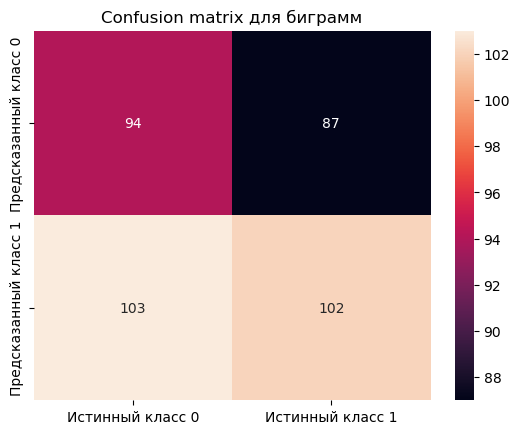

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np 
plt.title('Confusion matrix для биграмм')
sns.heatmap(pd.DataFrame(confusion_matrix(best2.predict(X_test_cv_bigram), y_valid.astype(np.int64)),\
                        columns=['Истинный класс 0', 'Истинный класс 1'], index=['Предсказанный класс 0', \
                               'Предсказанный класс 1']), annot=True, fmt='')

<Axes: title={'center': 'Confusion matrix для слов'}>

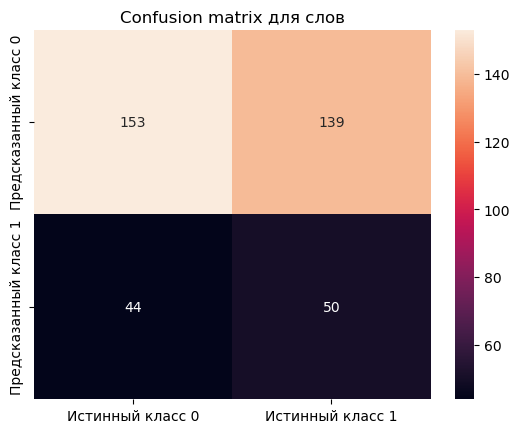

In [51]:
plt.title('Confusion matrix для слов')
sns.heatmap(pd.DataFrame(confusion_matrix(best3.predict(X_test_cv_word), y_valid.astype(np.int64)),\
                        columns=['Истинный класс 0', 'Истинный класс 1'], index=['Предсказанный класс 0', \
                               'Предсказанный класс 1']), annot=True, fmt='')

<Axes: title={'center': 'Confusion matrix для биграмм'}>

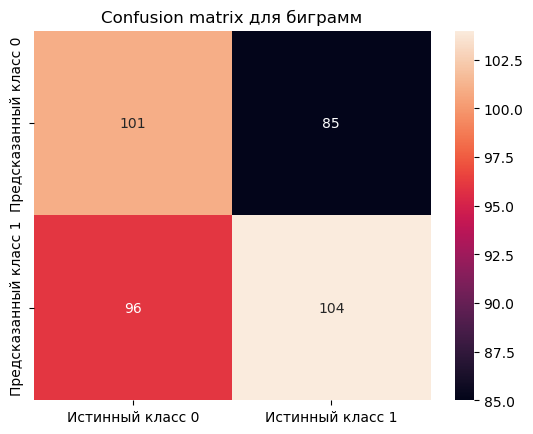

In [52]:
plt.title('Confusion matrix для биграмм')
sns.heatmap(pd.DataFrame(confusion_matrix(best.predict(X_test), y_valid.astype(np.int64)),\
                        columns=['Истинный класс 0', 'Истинный класс 1'], index=['Предсказанный класс 0', \
                               'Предсказанный класс 1']), annot=True, fmt='')

<Axes: title={'center': 'Confusion matrix для слов'}>

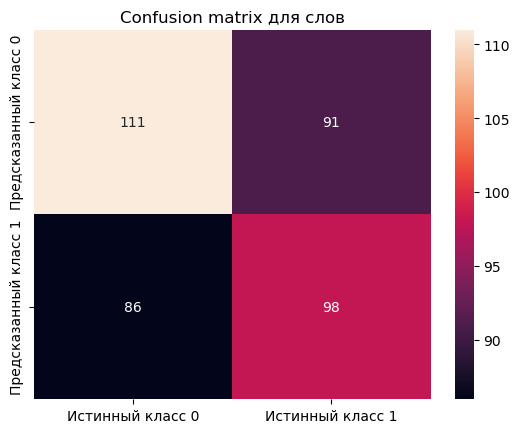

In [53]:
plt.title('Confusion matrix для слов')
sns.heatmap(pd.DataFrame(confusion_matrix(best1.predict(X_test1), y_valid.astype(np.int64)),\
                        columns=['Истинный класс 0', 'Истинный класс 1'], index=['Предсказанный класс 0', \
                               'Предсказанный класс 1']), annot=True, fmt='')

In [54]:
import matplotlib.pyplot as plt 
import numpy as np 
def visualize_coefficients(classifier, feature_names, name, n_top_features=25):
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.title(f'Топ 25 слов в словаре эмоциональной окраски для {name}')
    plt.xticks(
        np.arange(1, 1 + 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    );

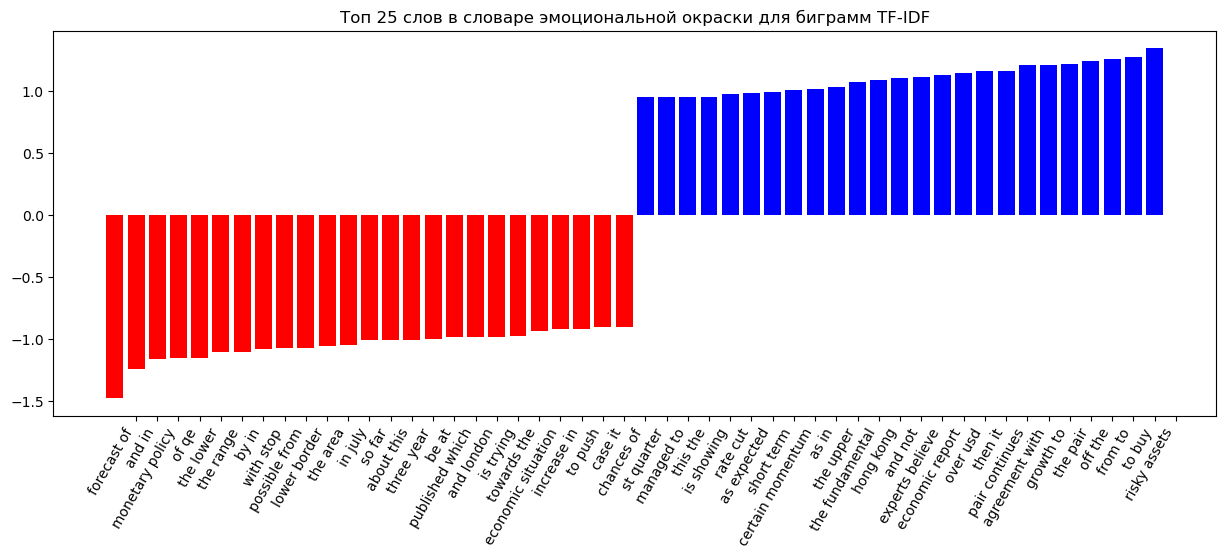

In [57]:
visualize_coefficients(best, tfid_bigram.get_feature_names_out(), 'биграмм TF-IDF')

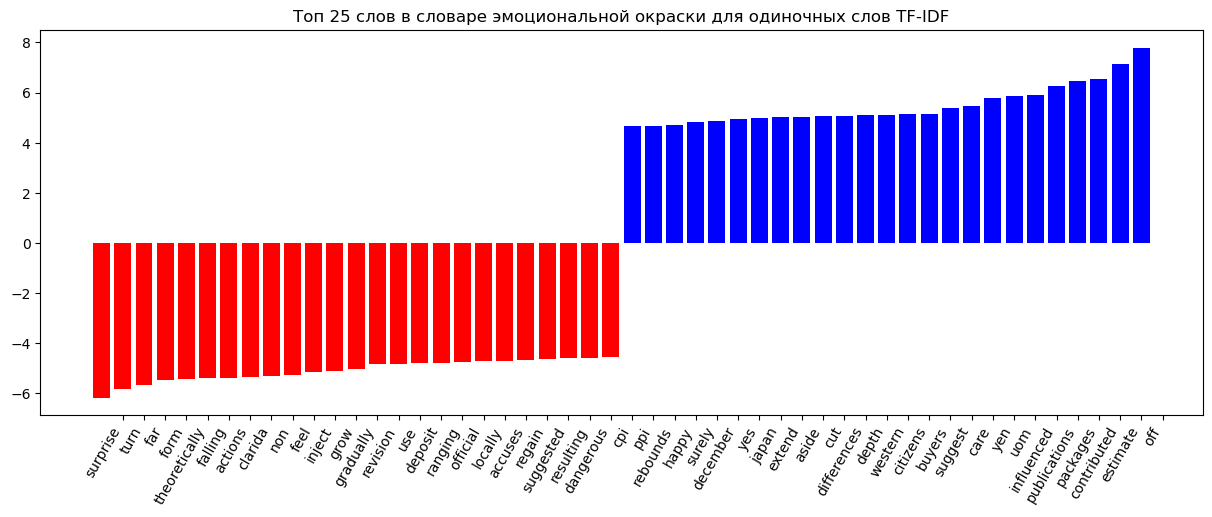

In [58]:
visualize_coefficients(best1, tfid_word.get_feature_names_out(), 'одиночных слов TF-IDF')

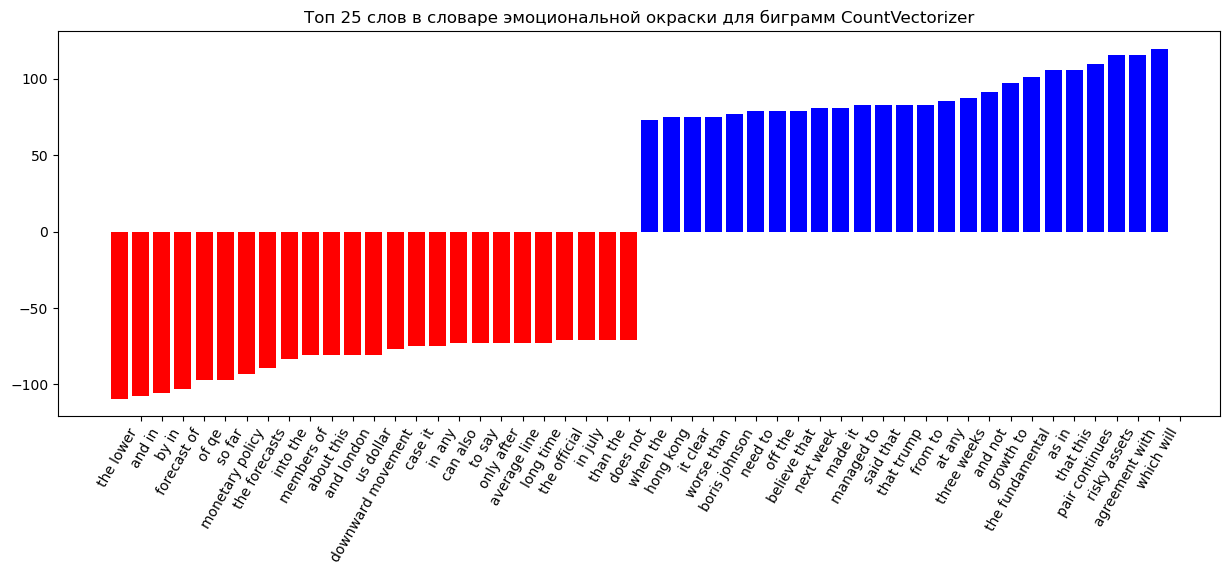

In [59]:
visualize_coefficients(best2, cv_bigram.get_feature_names_out(), 'биграмм CountVectorizer')

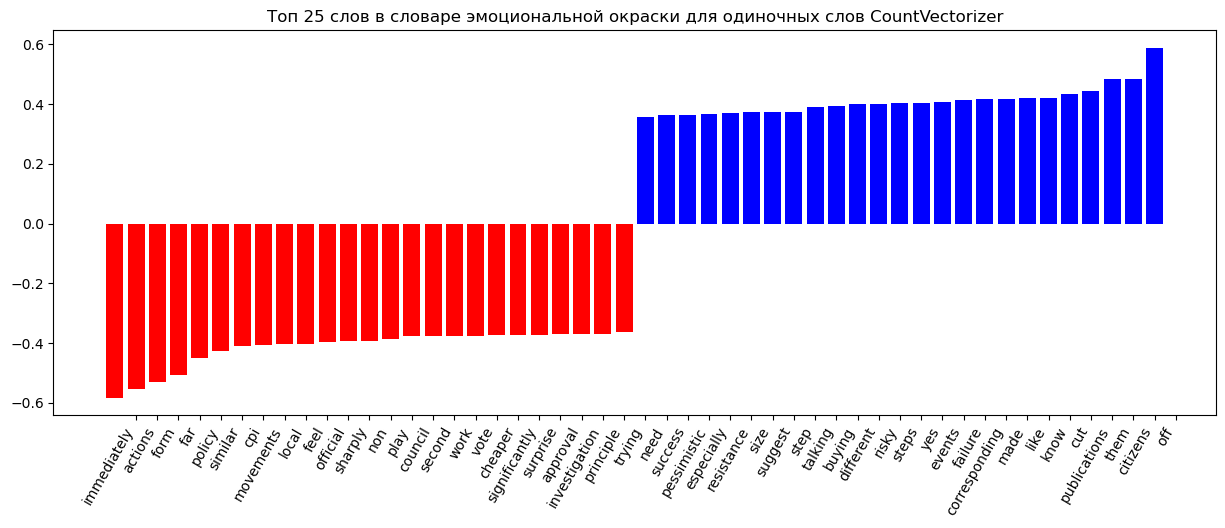

In [60]:
visualize_coefficients(best3, cv_word.get_feature_names_out(), 'одиночных слов CountVectorizer')

In [64]:
def save_dictionary(model, tfid, ngramm_name, path):
    coef = model.coef_.ravel() 
    feature_names = tfid.get_feature_names()
    indexes = np.argsort(coef)
    pd.DataFrame(np.vstack([np.array(feature_names)[indexes], sorted(coef)]).T, \
                 columns=[ngramm_name, 'Вес']).to_csv(path, sep=' ', index=None)
save_dictionary(best, tfid_bigram, 'Биграмма', b + 'bigrams_weights.csv')
save_dictionary(best1, tfid_word, 'Одиночное слово', b + 'words_weights.csv')

C:\Users\Андрей\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Андрей\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# CATBOOST AND RANDOMFOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
rf = CatBoostClassifier(iterations=2500, loss_function='CrossEntropy', random_seed=228)
data_train, data_test = Pool(X, y_train), Pool(X_test)
rf.fit(data_train)
accuracy_score(rf.predict(data_test), y_valid)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rft = RandomForestClassifier()
rft.fit(X, y_train)
accuracy_score(rft.predict(X_test), y_valid)